## 事实证明这些简单的方式都不靠谱，死活学不会

In [17]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils.folder import ImageFolder
from utils.common_utils import *
import visdom
import numpy as np

vis = visdom.Visdom()

plt.ion()   # interactive mode

## to start visdom server
sudo /home/yuan/anaconda3/bin/python -m visdom.server


In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.5, 0.5, 0.5,0.25])
    ]),
    'val': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
#         transforms.RandomResizedCrop(224),
        transforms.Resize(300),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.5, 0.5, 0.5,0.25])
    ]),
}

data_dir = 'data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [19]:
use_gpu

True

In [20]:
dataset_sizes

{'train': 92, 'val': 1}

In [21]:
# def pil_loader(path):
#     # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



_inputs.shape= torch.Size([4, 4, 224, 224])
inputs min 0.0
inputs max 1.0
alphas min 0.003921628
alphas max 1.0
inputs mean 0.51073235 0.42150903 0.38941324 0.013274939
inputs std 0.3211561 0.33621365 0.32134688 0.09282164


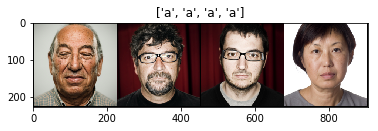

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch

inputs = _inputs[:,0:3,:,:]  # [-1,1]
inputs = inputs*0.5+0.5 #不需要clip  #[0,1]
print("inputs min",np.min(inputs.numpy()))
print("inputs max",np.max(inputs.numpy()))

alphas = _inputs[:,3:4,:,:] #[-1,1]
alphas = alphas*0.5+0.5 #不需要clip  #[0,1]
print("alphas min",np.min(alphas.numpy()))
print("alphas max",np.max(alphas.numpy()))

meanr = torch.mean(torch.FloatTensor(inputs[:,0,:,:])).numpy()
meang = torch.mean(torch.FloatTensor(inputs[:,1,:,:])).numpy()
meanb = torch.mean(torch.FloatTensor(inputs[:,2,:,:])).numpy()
meana = torch.mean(torch.FloatTensor(alphas[:,0,:,:])).numpy()

stdr = torch.std(torch.FloatTensor(inputs[:,0,:,:])).numpy()
stdg = torch.std(torch.FloatTensor(inputs[:,1,:,:])).numpy()
stdb = torch.std(torch.FloatTensor(inputs[:,2,:,:])).numpy()
stda = torch.std(torch.FloatTensor(alphas[:,0,:,:])).numpy()

print('inputs mean',meanr,meang,meanb,meana)
print('inputs std',stdr,stdg,stdb,stda)

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# img = np_to_pil(alphas[0].numpy())
# img.show() #显示方法之一
# img.save('bb.png')



In [23]:
# vis.image(out,win='in')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [24]:
def plotLosses():
    plt.plot(all_losses['train'],label='train')
    plt.plot(all_losses['val'],label='val')
    plt.legend()


In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    all_losses={'train':[],'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs ,labels没有用，只是必须有这层结构
                _inputs, labels = data
                #把alpha通道拆出来，作为label,剩下的作为rgb3通道input
#                 print('_inputs.shape=',_inputs.shape)
                inputs = _inputs[:,0:3,:,:]
                labels = _inputs[:,3:4,:,:]
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                #print('outputs mean =',torch.mean(outputs),torch.min(outputs),torch.max(outputs))
                #print('========= outputs===================',outputs[0])
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() * inputs.size(0)
                #show sample
                RGBAShow(inputs.cpu().detach().numpy()[0], a_np1= labels.cpu().detach().numpy()[0], a_np2 = outputs.cpu().detach().numpy()[0],phase = phase)

            epoch_loss = running_loss / dataset_sizes[phase]
            all_losses[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'train' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,all_losses

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [26]:
from models.skip import skip
from models.resnet import ResNet
from models.unet import UNet

pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
reg_noise_std = 1./30. # set to 1./20. for sigma=50
OPTIMIZER='adam' # 'LBFGS'
show_every = 500
num_iter=2400
input_depth = 3
figsize = 5 
dtype = (torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

NETTYPE = 'skip'
if NETTYPE == 'skip':
    net = skip(
            input_depth, num_output_channels=1, 
            num_channels_down = [8, 16, 32, 64, 128],
            num_channels_up   = [8, 16, 32, 64, 128],
            num_channels_skip = [ 4, 4, 4, 4, 4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')
    LR = 0.001
elif NETTYPE == 'RESNET':
    net = ResNet(3, 1, 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
    LR = 0.001
elif NETTYPE == 'UNet':
    net = UNet(num_input_channels=3, num_output_channels=1, 
           feature_scale=8, more_layers=1, 
           concat_x=False, upsample_mode='deconv', 
           pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
    LR = 0.001
    

net = net.type(dtype)
# print(net)

In [27]:
# for param in net.parameters():
#     print(type(param.data), param.size())
#     print(param.data)

# s = sum([np.prod(list(p.size())) for p in net.parameters() ])
# print(s)

In [28]:
# weights initializing is far important than you imaging
# learn from inpainting
for n in [x for x in net.parameters()]:
    n.data.normal_()

In [29]:
model_ft = net

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.MSELoss().type(dtype)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=LR, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=900, gamma=0.1)

In [30]:
def denomalize(nparray):
    #return nparray*0.5+0.5
    return np.clip(nparray,-1,1)*0.5+0.5


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [31]:
def RGBAShow(rgb_np,a_np1=None,a_np2=None,phase = ''):
    if phase == 'val':return
    vis.image(denomalize(rgb_np),win = 100,opts=dict(title=phase+'_rgb'))
    #     np_to_pil(rgb_np).show()
    if a_np1 is not None:
        vis.image(denomalize(a_np1),win = 110,opts=dict(title=phase+'_a1'))
        rgba1=np.concatenate((denomalize(rgb_np),denomalize(a_np1)),axis=0)
        vis.image(rgba1,win=111,opts=dict(title=phase+'_rgba1'))
    if a_np2 is not None:
        vis.image(denomalize(a_np2),win = 120,opts=dict(title=phase+'_a2_mask'))
        #rgba2=np.concatenate((denomalize(rgb_np),denomalize(a_np2)),axis=0)
        #vis.image(rgba2,win=121,opts=dict(title=phase+'_rgba2'))

        

In [ ]:
model_ft,all_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=250)

Epoch 0/249
----------


/home/yuan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train Loss: 0.2057
val Loss: 0.1396
Epoch 1/249
----------
train Loss: 0.0939
val Loss: 0.1002
Epoch 2/249
----------
train Loss: 0.0466
val Loss: 0.0998
Epoch 3/249
----------
train Loss: 0.0389
val Loss: 0.0977
Epoch 4/249
----------
train Loss: 0.0370
val Loss: 0.0965
Epoch 5/249
----------
train Loss: 0.0359
val Loss: 0.0960
Epoch 6/249
----------
train Loss: 0.0355
val Loss: 0.0979
Epoch 7/249
----------
train Loss: 0.0354
val Loss: 0.0956
Epoch 8/249
----------
train Loss: 0.0352
val Loss: 0.0956
Epoch 9/249
----------
train Loss: 0.0350
val Loss: 0.0953
Epoch 10/249
----------
train Loss: 0.0348
val Loss: 0.0956
Epoch 11/249
----------
train Loss: 0.0347
val Loss: 0.0963
Epoch 12/249
----------
train Loss: 0.0347
val Loss: 0.0971
Epoch 13/249
----------
train Loss: 0.0347
val Loss: 0.0951
Epoch 14/249
----------
train Loss: 0.0345
val Loss: 0.0962
Epoch 15/249
----------
train Loss: 0.0346
val Loss: 0.0962
Epoch 16/249
----------
train Loss: 0.0346
val Loss: 0.0953
Epoch 17/249


val Loss: 0.0725
Epoch 137/249
----------
train Loss: 0.0078
val Loss: 0.0705
Epoch 138/249
----------
train Loss: 0.0076
val Loss: 0.0692
Epoch 139/249
----------
train Loss: 0.0079
val Loss: 0.0751
Epoch 140/249
----------
train Loss: 0.0075
val Loss: 0.0739
Epoch 141/249
----------
train Loss: 0.0075
val Loss: 0.0746
Epoch 142/249
----------
train Loss: 0.0071
val Loss: 0.0728
Epoch 143/249
----------
train Loss: 0.0072
val Loss: 0.0770
Epoch 144/249
----------
train Loss: 0.0070
val Loss: 0.0742
Epoch 145/249
----------
train Loss: 0.0071
val Loss: 0.0814
Epoch 146/249
----------
train Loss: 0.0071
val Loss: 0.0779
Epoch 147/249
----------
train Loss: 0.0073
val Loss: 0.0742
Epoch 148/249
----------
train Loss: 0.0075
val Loss: 0.0759
Epoch 149/249
----------
train Loss: 0.0072
val Loss: 0.0726
Epoch 150/249
----------
train Loss: 0.0071
val Loss: 0.0668
Epoch 151/249
----------
train Loss: 0.0066
val Loss: 0.0682
Epoch 152/249
----------
train Loss: 0.0068
val Loss: 0.0752
Epoch 1

In [ ]:
plotLosses()

# Configs

#### SKIP, Adam , LR = 0.001 , one input, no schedual, no dropout , [ 4, 4, 4, 4, 4] = perfict fit
#### dropout = 0.01 = almost perfict
#### dropout = 0.1  = faile, output is a all-white image